<a href="https://colab.research.google.com/github/Him2001/Scalable-Fault-Diagnosis-in-Generators/blob/main/DTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FYP

/content/drive/MyDrive/FYP


In [ ]:
import pandas as pd
df = pd.read_csv(r"Train.csv")
X_train = df.drop(['Detection'], axis = 'columns')
Y_train = df.Detection
del df

df1 = pd.read_csv(r"5Overlap.csv")
X_test = df1.drop(['Detection'], axis = 'columns')
Y_test = df1.Detection
del df1
Y_test = Y_test.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import glob
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K
from keras import regularizers
from keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from keras.layers import GaussianNoise
import pandas as pd
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# define the MMD loss function
def mmd_loss(y_true, y_pred, weight=1.0):
    # calculate the MMD loss
    mmd_loss = K.mean(tf.square(tf.reduce_mean(y_pred, axis=0) - tf.reduce_mean(y_true, axis=0)))

    # apply the weight to the MMD loss
    mmd_loss = weight * mmd_loss

    return mmd_loss

# define the binary cross-entropy + MMD loss function
def binary_crossentropy_mmd_loss(y_true, y_pred):
    # define the binary cross-entropy loss
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    bce_loss = K.binary_crossentropy(y_true, y_pred)

    # define the weight for the MMD loss
    mmd_weight = 0.1

    # calculate the MMD loss
    mmd = mmd_loss(y_true, y_pred, weight=mmd_weight)

    # combine the losses
    loss = bce_loss + mmd

    return loss

input_signal = Input(shape=(3000,))
encoded = Dense(2000, activation='relu', use_bias=True)(input_signal)
encoded = Dense(1000, activation='relu', use_bias=True)(encoded)
encoded = Dense(500, activation='relu', use_bias=True,activity_regularizer=regularizers.l1(10e-5))(encoded)
encoded = Dense(250, activation='relu', use_bias=True,activity_regularizer=regularizers.l1(10e-5))(encoded)
bottleneck = Dense(10,activation='relu', use_bias=True)(encoded)

# Define decoder layers
decoded1 = Dense(250,activation='relu',use_bias=True)(bottleneck)
decoded1 = Dense(500,activation='relu',use_bias=True)(decoded1)
decoded1 = Dense(1000,activation='relu',use_bias=True)(decoded1)
decoded1 = Dense(2000,activation='relu',use_bias=True)(decoded1)
decoded = Dense(3000,activation='linear',use_bias=True)(decoded1)
autoencoder = Model(input_signal, decoded, name='autoencoder')
# Define autoencoder model
autoencoder.compile(loss='mse',optimizer=keras.optimizers.Adam(),metrics=['accuracy'])


den = Dense(125, activation='relu',activity_regularizer=regularizers.l1(10e-5))(bottleneck)
# noise = GaussianNoise(0.1)(den)
out = Dense(1, activation='sigmoid')(den)
classification_model = Model(input_signal,out)

for l1,l2 in zip(classification_model.layers[:6],autoencoder.layers[0:6]):
    l1.set_weights(l2.get_weights())
for layer in classification_model.layers[0:5]:
    layer.trainable = False

classification_model.compile(loss=binary_crossentropy_mmd_loss, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
  # Extract features from input data using the feature extractor
X_train = np.array(X_train)
X_test= np.array(X_test)

In [ ]:

autoencoder.fit(X_train,X_train, epochs = 20,shuffle = True,batch_size = 200,verbose  ='auto')
classification_model.fit(X_train,Y_train, epochs = 20, shuffle = True,batch_size = 200,verbose  ='auto')


Epoch 1/20
256/256 [==============================] - 11s 11ms/step - loss: 50.2421 - accuracy: 0.0230
Epoch 2/20
256/256 [==============================] - 3s 11ms/step - loss: 9.5805 - accuracy: 0.1285
Epoch 3/20
256/256 [==============================] - 3s 11ms/step - loss: 1.1000 - accuracy: 0.2972
Epoch 4/20
256/256 [==============================] - 3s 12ms/step - loss: 0.3848 - accuracy: 0.3181
Epoch 5/20
256/256 [==============================] - 3s 11ms/step - loss: 0.7236 - accuracy: 0.3178
Epoch 6/20
256/256 [==============================] - 3s 11ms/step - loss: 1.2373 - accuracy: 0.3092
Epoch 7/20
256/256 [==============================] - 3s 11ms/step - loss: 108.0051 - accuracy: 0.0327
Epoch 8/20
256/256 [==============================] - 3s 11ms/step - loss: 9.8198 - accuracy: 0.1169
Epoch 9/20
256/256 [==============================] - 3s 12ms/step - loss: 0.1910 - accuracy: 0.2309
Epoch 10/20
256/256 [==============================] - 3s 11ms/step - loss: 0.0343 - ac

In [ ]:

x = classification_model.layers[1](X_train)
x = classification_model.layers[2](x)
x = classification_model.layers[3](x)
x = classification_model.layers[4](x)
X_train_features = classification_model.layers[5](x).numpy()

y = classification_model.layers[1](X_test)
y = classification_model.layers[2](y)
y = classification_model.layers[3](y)
y = classification_model.layers[4](y)
X_test_features = classification_model.layers[5](y).numpy()

# Apply t-SNE to the extracted features
tsne = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne.fit_transform(X_train_features)
X_test_tsne = tsne.fit_transform(X_test_features)


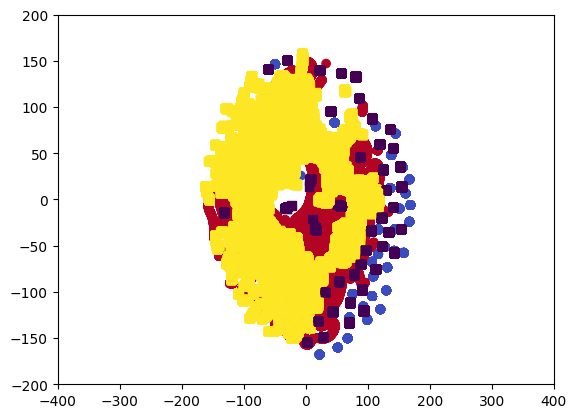

In [ ]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=Y_train, cmap='coolwarm', marker='o')
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=Y_test, cmap='viridis', marker='s')
plt.xlim(-400, 400)
plt.ylim(-200, 200)
plt.show()




In [ ]:

ls = classification_model.predict(X_test)
rs = []
for i in ls:
    if (i >= 0.5):
        rs.append(1)
    else:
        rs.append(0)
j = accuracy_score(Y_test, rs)*100
print(j)

1281/1281 [==============================] - 2s 2ms/step
80.6791569086651
